## Sentiment Result Analysis

**The notebook in ipynb doesn't save plotly graphs. Please view html format for interactive graphs.**

### 7. What is the overall attitude for Pokémon in related subreddit?
Business goal: Perform sentiment analysis on Pokémon subreddits posts. Determine the overall attributes in each subreddits.

Technical proposal: Use NLP to clean submission and comment texts. Split texts into sentences and convert all words into lowercase. Remove html links, punctuations, stop words, and special characters (emoji) from sentences. Use a pretrained sentiment analysis model and build Spark NLP pipeline. Use the pipeline to perform sentiment analysis on submission and comment bodies. Count number of sentiments in subreddits and present the result as a table.

In [0]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import plotly.express as px
import numpy as np

In [0]:
pokemon_sentiments = spark.read.parquet("/FileStore/pokemon_comments_sentiment")
pokemon_sentiments.show(10, truncate=False)

+---------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-----+---------+
|subreddit            |body                                                                                                                                                                                

Count number of sentiments and compute proportions.

In [0]:
# count number of sentiments
overall_sentiments = pokemon_sentiments.groupBy("sentiment").count().toPandas()
# compute proportions
overall_sentiments["proportion"] = round(overall_sentiments["count"]/sum(overall_sentiments["count"])*100,3)
overall_sentiments

,sentiment,count,proportion
0,positive,6802143,61.571
1,neutral,606769,5.492
2,negative,3638687,32.936


##### Figure.1 Number of sentiments in top 5 Pokémon subreddits

Plot number of sentiments in top 5 Pokémon subreddits. Plot a bar graph and a pie chart side by side.

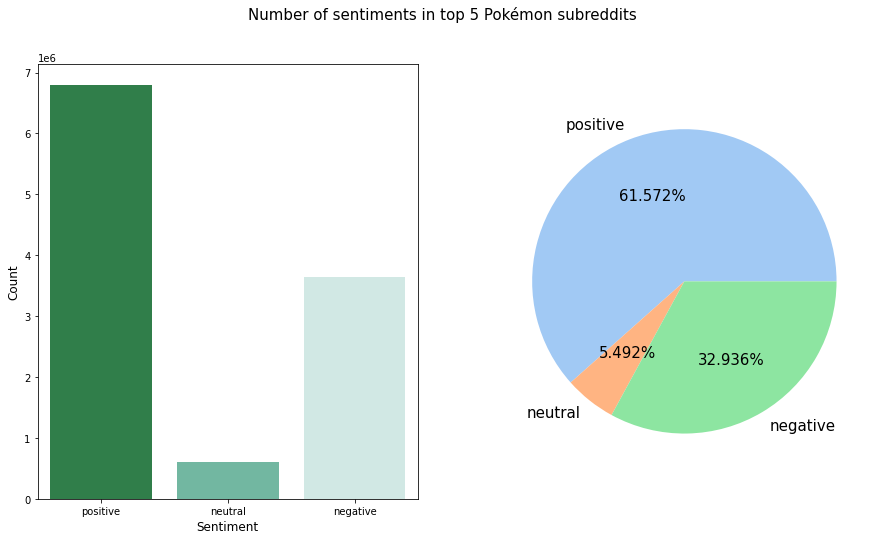

In [0]:
# Plot number of sentiments in top 5 Pokémon subreddits
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
# plot bar graph
plot_1 = sns.barplot(ax=ax[0], x="sentiment", y="count", data=overall_sentiments, palette=sns.color_palette("BuGn_r", n_colors = 3))
plot_1.set_xlabel("Sentiment", fontsize=12)
plot_1.set_ylabel("Count", fontsize=12)
# plot pie chart
ax[1].pie(overall_sentiments["proportion"], labels = overall_sentiments["sentiment"], colors = sns.color_palette('pastel'), autopct='%.3f%%',textprops={'fontsize': 15})
fig.suptitle("Number of sentiments in top 5 Pokémon subreddits", fontsize=15)
plot_fpath = os.path.join("../../data/plots", "overall_sentiment.png")
fig.savefig(plot_fpath)
fig.show()

The table above shows people's overall sentiment toward Pokemon products from January 2021 to August 2022. Positive sentiment is about 61.5% of all sentiments and negative sentiment is about 32.9%. The significantly higher number of positive sentiments than the negative sentiments indicates that Pokemon fans are overall satisfied with Pokemon products. About 5.5% of the neutral statements also showed that fans have a clear preference for Pokémon. Everyone is willing to share their positive or negative views on Reddit. More than 30% of the negative comments are also worthy of further study. Exploring the key contents of specific discussions can help Pokémon continuously optimize the user experience.

Count number of sentiments by subreddit.

In [0]:
# transfer UNIX timestamp to human readable date
pokemon_sentiments = pokemon_sentiments.withColumn("year", f.from_unixtime(f.col("created_utc"), "yyyy"))
# count number of sentiments by subreddit
sentiments_by_sub = pokemon_sentiments.groupby("subreddit", "sentiment").count().orderBy("subreddit", "sentiment").toPandas()
sentiments_by_sub

,subreddit,sentiment,count
0,PokemonSwordAndShield,negative,378539
1,PokemonSwordAndShield,neutral,69449
2,PokemonSwordAndShield,positive,1047827
3,PokemonTCG,negative,631587
4,PokemonTCG,neutral,97892
5,PokemonTCG,positive,888491
6,pokemon,negative,1451784
7,pokemon,neutral,246541
8,pokemon,positive,2464743
9,pokemongo,negative,834197


The table above is redundant in format, so we decide to transform the table to a more concise format.

In [0]:
# Table.1
# Number of sentiments by subreddit
df_sentiment =  pd.DataFrame([sentiments_by_sub["count"][2::-1].tolist()], columns=["positive", "neutral", "negative"])
i = 1
for i in range(1,5):
    content = sentiments_by_sub["count"][2+3*i:2+3*(i-1):-1].tolist()
    df_sentiment.loc[i] = content
df_sentiment.index = ["PokemonSwordAndShield", "PokemonTCG", "pokemon", "pokemongo", "pokemontrades"]
df_sentiment.sort_values(by=["positive"], ascending=False, inplace=True)
df_sentiment

,positive,neutral,negative
pokemon,2464743,246541,1451784
pokemontrades,1576282,109630,342580
PokemonSwordAndShield,1047827,69449,378539
PokemonTCG,888491,97892,631587
pokemongo,824800,83257,834197


**Table.1 Number of sentiments by subreddit**

The subreddit pokemon receives the most number of comments among all top subreddits. The ratio of positive sentiments for pokemon, pokemontrades, and PokemonSwordAndShield are 59.20%, 77.71%, and 70.05%. But The number of negative sentiments of the subreddit pokemongo and PokemonTCG is higher than the other subreddits. These two games as key projects have received a large number of negative comments. First, we boldly speculate that the source of negative comments may be the mechanism, difficulty, or quality of the game. In the following steps, we can focus on the content analysis. 
Subreddit pokemontrades has the highest proportion of positive comments. The reason why pokemontrade got the highest positive comment should be that the players thanked each other.

Count number of sentiments over months

In [0]:
# transfer UNIX timestamp to human readable date
pokemon_sentiments = pokemon_sentiments.withColumn("month", f.from_unixtime(f.col("created_utc"), "yyyy-MM"))
# create dummy for sentiments
pokemon_sentiments = pokemon_sentiments.withColumn("positive_dummy", (f.col("sentiment") == "positive").cast('int')) \
    .withColumn("negative_dummy", (f.col("sentiment") == "negative").cast('int')) \
    .withColumn("neutral_dummy", (f.col("sentiment") == "neutral").cast('int'))

# count number of sentiments over months
sentiment_by_month = pokemon_sentiments.groupBy("month") \
    .agg(f.sum(f.col("positive_dummy")).alias("positve"), f.sum(f.col("negative_dummy")).alias("negative"),
        f.sum(f.col("neutral_dummy")).alias("neutral")) \
    .sort(f.col("month").desc()) \
    .toPandas()
# Table.2
# Number of sentiments over months
sentiment_by_month

,month,positve,negative,neutral
0,2022-08,358279,184738,31495
1,2022-07,290527,173009,26657
2,2022-06,252154,166717,24214
3,2022-05,242130,151777,23452
4,2022-04,260883,146696,23358
5,2022-03,340096,186104,30782
6,2022-02,333412,188912,29745
7,2022-01,541346,253459,44308
8,2021-12,618325,263906,49203
9,2021-11,564800,288650,56577


**Table.2 Number of sentiments over months**

From November 2021 to January 2022, the number of sentiments is significantly greater than other months. We tentatively speculate that it is because of the player interaction events of Pokemon Go.
Pokémon GO Community Day is a monthly in-game event in Pokémon GO that features specific Pokémon through limited-time increased spawn rates and obtainable exclusive moves for three hours. Recent Community Day events have allowed players to obtain these exclusive moves up to two hours after the regular time window.
On January 4, 2022, Niantic announced Community Day Classic, which are returns of previous Community Days in the same month as the original events, but on a different date. Community Day Classics last for three hours. Another possible reason is the release of two new Pokémon games: Pokémon Brilliant Diamond & Shining Pearl on November 19, 2021 and Pokémon Legends: Arceus on January 28, 2022. Two Pokémon games in three months should significantly increase people's discussion in this period. After this period, number of sentiments gradually decrease to the normal level.

In order to investigate further details about how sentiments change over time, we decide to separately plot number of positive and negative sentiments changes over time.

In [0]:
# transfer UNIX timestamp to human readable date
pokemon_sentiments = pokemon_sentiments.withColumn("date", f.from_unixtime(f.col("created_utc"), "yyyy-MM-dd"))

# count number of positive sentiments over days
sentiment_by_date = pokemon_sentiments.filter(f.col("sentiment") == "positive") \
    .groupBy("date", "subreddit") \
    .agg(f.count(f.col("sentiment")).alias("positve_sentiment")) \
    .sort(f.col("date").desc()) \
    .toPandas()
    
sentiment_by_date

,date,subreddit,positve_sentiment
0,2022-08-31,PokemonSwordAndShield,1557
1,2022-08-31,PokemonTCG,1809
2,2022-08-31,pokemontrades,1260
3,2022-08-31,pokemon,2986
4,2022-08-31,pokemongo,2728
...,...,...,...
3035,2021-01-01,pokemontrades,2906
3036,2021-01-01,PokemonTCG,1167
3037,2021-01-01,PokemonSwordAndShield,1804
3038,2021-01-01,pokemon,2609


In [0]:
# count the number of negative sentiments over days
sentiment_by_date_neg = pokemon_sentiments.filter(f.col("sentiment") == "negative") \
    .groupBy("date", "subreddit") \
    .agg(f.count(f.col("sentiment")).alias("negative_sentiment")) \
    .sort(f.col("date").desc()) \
    .toPandas()

# merge the three dataframes
sentiment_by_date_all = pd.merge(sentiment_by_date, sentiment_by_date_neg, on=['date', 'subreddit'])

# compute the ratio of positive sentiments
sentiment_by_date_all['positive_ratio'] = sentiment_by_date_all['positve_sentiment'] / (sentiment_by_date_all['positve_sentiment'] + sentiment_by_date_all['negative_sentiment'])

sentiment_by_date_all

,date,subreddit,positve_sentiment,negative_sentiment,positive_ratio
0,2022-08-31,PokemonSwordAndShield,1557,575,0.730300
1,2022-08-31,PokemonTCG,1809,1031,0.636972
2,2022-08-31,pokemontrades,1260,223,0.849629
3,2022-08-31,pokemon,2986,1485,0.667860
4,2022-08-31,pokemongo,2728,1855,0.595243
...,...,...,...,...,...
3035,2021-01-01,pokemontrades,2906,645,0.818361
3036,2021-01-01,PokemonTCG,1167,943,0.553081
3037,2021-01-01,PokemonSwordAndShield,1804,696,0.721600
3038,2021-01-01,pokemon,2609,1229,0.679781


In [0]:
# change dataframe to time series format
df_positive = sentiment_by_date[sentiment_by_date.subreddit == "pokemon"][["date", "positve_sentiment"]]
df_positive.columns = ["date", "pokemon"]
 
list_pokemontcg = sentiment_by_date[sentiment_by_date.subreddit == "PokemonTCG"].positve_sentiment.tolist()
list_pokemongo = sentiment_by_date[sentiment_by_date.subreddit == "pokemongo"].positve_sentiment.tolist()
list_pokemontrades = sentiment_by_date[sentiment_by_date.subreddit == "pokemontrades"].positve_sentiment.tolist()
list_PokemonSwordAndShield = sentiment_by_date[sentiment_by_date.subreddit == "PokemonSwordAndShield"].positve_sentiment.tolist()
df_positive = df_positive.assign(PokemonTCG=list_pokemontcg, pokemongo=list_pokemongo, 
                                 pokemontrades=list_pokemontrades, PokemonSwordAndShield=list_PokemonSwordAndShield)
df_positive

,date,pokemon,PokemonTCG,pokemongo,pokemontrades,PokemonSwordAndShield
3,2022-08-31,2986,1809,2728,1260,1557
9,2022-08-30,4026,1564,2501,1457,1790
11,2022-08-29,11015,1272,2254,1503,1247
15,2022-08-28,9648,1548,2994,1806,1948
22,2022-08-27,3011,1736,2867,1687,1742
...,...,...,...,...,...,...
3017,2021-01-05,3099,1372,962,2543,1931
3024,2021-01-04,3067,1330,954,2233,1905
3028,2021-01-03,1748,1234,980,3116,2455
3034,2021-01-02,1862,1099,1007,2906,2551


#### Figure.2 Number of positive sentiments over days

Plot number of positive sentiments over time.

In [0]:
# Plot number of positive sentiments over days
fig = px.line(df_positive, x="date", y=df_positive.columns,
              hover_data={"date": "|%B %d, %Y"},
              title="Number of positive sentiment in top 5 most popular Pokemon subreddits")
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.write_html("../../data/plots/positive_sentiment.html")
fig.show()

February 27th, 2021 is the 26th anniversary of Pokemon. Thus, major releases and announcements regarding the series will be released on or around that specific day. That explains why the number of positive sentiments goes up on February 26th. The same reason holds for the increase in February 2022. Suggesting that annual product events can burst interest among fans and related social communities. The number of positive sentiments shows an increase around November 2021 for the majority of the top 5 subreddits. Mainly because of a bunch of new releases and updates. August 2022, Pokemon World Championships for PokemonTCG. Another large community event that brought up interest among followers and the general public.

Compute proportion of positive sentiment to further investigate sentiment change.

In [0]:
# change dataframe to time series format
df_positive_ratio = sentiment_by_date_all[sentiment_by_date_all.subreddit == "pokemon"][["date", "positive_ratio"]]
df_positive_ratio.columns = ["date", "pokemon"]
 
list_pokemontcg_r = sentiment_by_date_all[sentiment_by_date_all.subreddit == "PokemonTCG"].positive_ratio.tolist()
list_pokemongo_r = sentiment_by_date_all[sentiment_by_date_all.subreddit == "pokemongo"].positive_ratio.tolist()
list_pokemontrades_r = sentiment_by_date_all[sentiment_by_date_all.subreddit == "pokemontrades"].positive_ratio.tolist()
list_PokemonSwordAndShield_r = sentiment_by_date_all[sentiment_by_date_all.subreddit == "PokemonSwordAndShield"].positive_ratio.tolist()

df_positive_ratio = df_positive_ratio.assign(PokemonTCG=list_pokemontcg_r, pokemongo=list_pokemongo_r, 
                                 pokemontrades=list_pokemontrades_r, PokemonSwordAndShield=list_PokemonSwordAndShield_r)
df_positive_ratio

,date,pokemon,PokemonTCG,pokemongo,pokemontrades,PokemonSwordAndShield
3,2022-08-31,0.667860,0.636972,0.595243,0.849629,0.730300
9,2022-08-30,0.726846,0.588634,0.575604,0.825964,0.748328
11,2022-08-29,0.740853,0.590804,0.579583,0.822210,0.716667
15,2022-08-28,0.698827,0.647699,0.574333,0.850282,0.790584
22,2022-08-27,0.651168,0.605511,0.577326,0.869588,0.724324
...,...,...,...,...,...,...
3017,2021-01-05,0.597225,0.531783,0.522542,0.794191,0.735059
3024,2021-01-04,0.622362,0.500376,0.572286,0.771596,0.711883
3028,2021-01-03,0.608423,0.552620,0.573099,0.836735,0.746882
3034,2021-01-02,0.649459,0.536098,0.533934,0.833381,0.742217


#### Figure.3 Ratio of positive sentiments over days

Plot ratio of positive sentiments over days

In [0]:
# Plot ratio of positive sentiments over days
fig = px.line(df_positive_ratio, x="date", y=df_positive_ratio.columns,
              hover_data={"date": "|%B %d, %Y"},
              title="Ratio of positive sentiment in top 5 most popular Pokemon subreddits")
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.write_html("../../data/plots/positive_sentiment_ratio.html")
fig.show()

Overall, PokemonTrades subreddits as the main trading platform, most sentiments are positive. Compared with several popular Pokémon games, Pokemon Sword and Shield has the most stable performance and the highest positive rate, which is basically stable at more than 70%. Only in October 2021 and February 2022,  it decreases slightly, but it will recover back soon. It shows that the overall satisfaction of players is good. 
In contrast, the overall positive rates of pokemonTCG and Pokemongo are low. Before August 2021, the positive sentiments rates of both games fluctuated between 50% - 60%, and Pokemongo was more unstable. After August, the overall trend of PokemonTCG has improved, with the average positive sentiments rates rose to about 60%, sometimes even 70%. However, the overall trend of Pokemongo declined significantly after August, with only 30% in June 2022. We can judge that fans are obviously dissatisfied with the version after August. The good news is that after August 22, the positive sentiments rates has recovered.

Plot number of negative sentiments over days

In [0]:
# count number of negative sentiments over days
negative_by_date = pokemon_sentiments.filter(f.col("sentiment") == "negative") \
    .groupBy("date", "subreddit") \
    .agg(f.count(f.col("sentiment")).alias("negative_sentiment")) \
    .sort(f.col("date").desc()) \
    .toPandas()
    
negative_by_date

,date,subreddit,negative_sentiment
0,2022-08-31,PokemonSwordAndShield,575
1,2022-08-31,PokemonTCG,1031
2,2022-08-31,pokemontrades,223
3,2022-08-31,pokemon,1485
4,2022-08-31,pokemongo,1855
...,...,...,...
3035,2021-01-01,pokemontrades,645
3036,2021-01-01,PokemonTCG,943
3037,2021-01-01,PokemonSwordAndShield,696
3038,2021-01-01,pokemon,1229


In [0]:
# change dataframe to time series format
df_negative = negative_by_date[sentiment_by_date.subreddit == "pokemon"][["date", "negative_sentiment"]]
df_negative.columns = ["date", "pokemon"]
 
list_pokemontcg = negative_by_date[negative_by_date.subreddit == "PokemonTCG"].negative_sentiment.tolist()
list_pokemongo = negative_by_date[negative_by_date.subreddit == "pokemongo"].negative_sentiment.tolist()
list_pokemontrades = negative_by_date[negative_by_date.subreddit == "pokemontrades"].negative_sentiment.tolist()
list_PokemonSwordAndShield = negative_by_date[negative_by_date.subreddit == "PokemonSwordAndShield"].negative_sentiment.tolist()
df_negative = df_negative.assign(PokemonTCG=list_pokemontcg, pokemongo=list_pokemongo, 
                                 pokemontrades=list_pokemontrades, PokemonSwordAndShield=list_PokemonSwordAndShield)
df_negative

,date,pokemon,PokemonTCG,pokemongo,pokemontrades,PokemonSwordAndShield
3,2022-08-31,1485,1031,1855,223,575
9,2022-08-30,1513,1093,1844,307,602
11,2022-08-29,3853,881,1635,325,493
15,2022-08-28,4158,842,2219,318,516
22,2022-08-27,1613,1131,2099,253,663
...,...,...,...,...,...,...
3017,2021-01-05,2090,1208,879,659,696
3024,2021-01-04,1861,1328,713,661,771
3028,2021-01-03,1125,999,730,608,832
3034,2021-01-02,879,951,879,581,886


#### Figure.4 Number of negative sentiments in top 5 subreddits over days

In [0]:
# Figure.4
# Plot Number of negative sentiments in top 5 subreddits over days
fig = px.line(df_negative, x="date", y=df_negative.columns,
              hover_data={"date": "|%B %d, %Y"},
              title="Number of negative sentiment in top 5 most popular Pokemon subreddits")
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.write_html("../../data/plots/negative_sentiment.html")
fig.show()

In preparation for celebrating the Pokemon anniversary on February 27th, the Pokemon Company featured a Pokemon Presents presentation on February 26th, 2021. The presentation introduces the latest updates on current Pokemon products, such as Pokemon Snap and Pokemon Sword and Shield, as well as the releases of new games, such as the remakes of Pokemon Brilliant Diamond and Pokemon Shining Pearl. As the annual event boosted positive discussions among the Reddit communities, it might bring up the number of negative discussions among the top subreddits as well. It's worth to notice that this Pokemon Presents received more negative sentiments than positive sentiments in Reddit on February 26th, 2021. This indicated people's unsatisfaction of future Pokemon new products. Thus, it can be concluded that an annual event must be designed and carried out carefully and wisely to attract worldwide fans.

To investigate word patterns in positive and negative sentiments, we decide to create a wordcloud for each sentiment

In [0]:
# filter postive sentiment
# select top 10000 comments
positive_10000 = pokemon_sentiments.filter(f.col("sentiment") == "positive") \
    .orderBy("score", ascending=False) \
    .limit(10000).select("body_clean", "score") \
    .rdd.map(lambda x: x[0]).collect()

In [0]:
!pip install wordcloud
!pip install nltk
nltk.download('stopwords')

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-a08db76b-d51b-4aca-b458-3ef967f13d2e/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-a08db76b-d51b-4aca-b458-3ef967f13d2e/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Out[13]: True

#### Figure.5 Wordcloud of positive sentiments

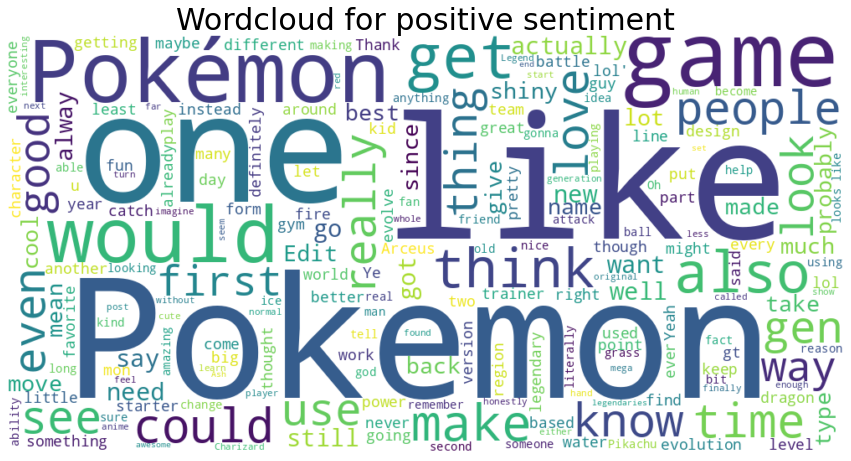

In [0]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
# Wordcloud of positive sentiments
stopwords = nltk.corpus.stopwords.words('english')
positive_wordcloud = WordCloud(background_color="white", width=1000, height=500, stopwords=stopwords).generate(str(positive_10000)) # width=1000, height=500, 

plt.figure(figsize=(15,30))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Wordcloud for positive sentiment", fontsize=30)
plt.axis('off')
plot_fpath = os.path.join("../../data/plots", "positive_wordcloud.png")
plt.savefig(plot_fpath)
plt.show()

Apart from the center word 'Pokemon' and 'game', the positive sentiments mainly include positive words such as 'like', 'best', and 'love'. That makes sense intuitively since those words are often used when people express positive feelings about certain things. An interesting phenomenon is that action words like 'would', 'get', 'make', and 'think' appears much more frequently than expected. words like 'design', 'ability', 'evolution' also reflect the players' recognition of these aspects of game. 'fire', 'dragon', 'charizard', These words prove once again that fans love the Charizard.

In [0]:
# filter postive sentiment
# select top 10000 comments
negative_10000 = pokemon_sentiments.filter(f.col("sentiment") == "negative") \
    .orderBy("score", ascending=False) \
    .limit(10000).select("body_clean", "score") \
    .rdd.map(lambda x: x[0]).collect()

#### Figure.6 Wordcloud of negative sentiments

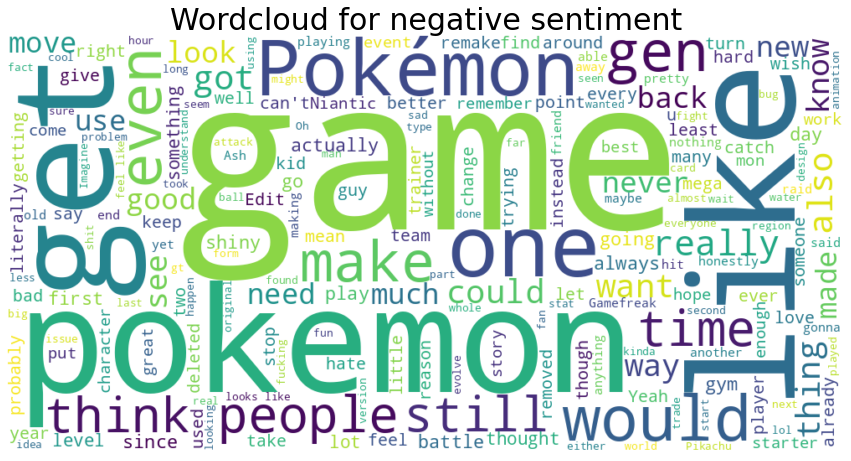

In [0]:
# Wordcloud of negative sentiments
stopwords = nltk.corpus.stopwords.words('english')
positive_wordcloud = WordCloud(background_color="white", width=1000, height=500, stopwords=stopwords).generate(str(negative_10000))

plt.figure(figsize=(15,30))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Wordcloud for negative sentiment", fontsize=30)
plt.axis('off')
plot_fpath = os.path.join("../../data/plots", "negative_wordcloud.png")
plt.savefig(plot_fpath)
plt.show()

Words like 'Pokemon' and 'game' show higher frequencies compared to other words given the chosen topic. Word 'like' seems somewhat weird here among comments with negative sentiments. The major drawback of sentiment analysis is that it suffers a lot from the specific context and language. Since the word 'like' can have multiple meanings in different context settings and may also be a verb sometimes, the result is acceptable. Most of the words shown are negative words, despite a few such as 'better' and 'good'. It is possible that the majority of words in the context of these few positive components have negative meanings, so those comments get classified as negative. Also, note that these positive words may not always be associated with positive feelings depending on the specific context. Overall, the content of negative sentiments is logical and consistent with common sense. 
Words such as 'still','think','would', 'also', 'literally','pribably' reflects reflect that players contain many suggestions or reviews in their negative comments, and the content after these words may be more valuable. In a positive direction, players are willing to share their insights. Later, we may explore how to dig more deeply into this information.

For following analysis, we decide to use regex to identify topics and analyze sentiments in these topics. We analyze the following three topics:

1. sentiment of three popular pokemons, Charizard, Pikachu and Eevee

2. sentiment of four games

3. sentiment of anime, Pokémon Journeys: The Series

In [0]:
# create dummy variables for Pokémon by searching Pokémon names
pokemon_sentiments = spark.read.parquet("/FileStore/pokemon_comments_sentiment")
pokemon_sentiments.show(10)

+--------------------+--------------------+--------------------+-----------+-----+---------+
|           subreddit|                body|          body_clean|created_utc|score|sentiment|
+--------------------+--------------------+--------------------+-----------+-----+---------+
|PokemonSwordAndSh...|Yh for an ‘unbeat...|Yh for an ‘unbeat...| 1632898368|   26| negative|
|             pokemon|           [removed]|           [removed]| 1632898375|   -1| negative|
|PokemonSwordAndSh...|When i dont have ...|When i dont have ...| 1632898375|    1| negative|
|             pokemon|a different palet...|a different palet...| 1632898394|    2| positive|
|          PokemonTCG|I mean when I fou...|I mean when I fou...| 1632898400|    1| negative|
|          PokemonTCG|Oh my sweet Chris...|Oh my sweet Chris...| 1632898406|    2| positive|
|             pokemon|     This is amazing|     This is amazing| 1632898412|    1| positive|
|             pokemon|Applied to type a...|Applied to type a...| 16328

In [0]:
# Table.3
# Number of sentiments received by Pokemon
pokemon_sentiments = pokemon_sentiments.withColumn("Charizard", f.col("body").rlike("(?i)charmander|(?i)charmeleon|(?i)charizard").cast("int")) \
    .withColumn("Pikachu", f.col("body").rlike("(?i)pichu|(?i)pikachu|(?i)raichu").cast("int")) \
    .withColumn("Eevee", f.col("body").rlike("(?i)Vaporeon|(?i)Jolteon|(?i)Flareon|(?i)Espeon|(?i)Umbreon|(?i)Leafeon|(?i)Glaceon|(?i)Sylveon").cast("int")) \
    .withColumn("Weather_Trio", f.col("body").rlike("(?i)Kyogre|(?i)Groudon|(?i)Rayquaza").cast("int")) \
    .withColumn("Legendary_Beasts", f.col("body").rlike("(?i)Raikou|(?i)Entei|(?i)Suicune|(?i)Lugia|(?i)Ho-oh").cast("int")) \
    .withColumn("Creation_Trio", f.col("body").rlike("(?i)Dialga|(?i)Palkia|(?i)Giratina").cast("int"))

sentiments_by_pokemon = pokemon_sentiments.groupBy("sentiment") \
    .agg(f.sum("Charizard").alias("Charizard"), f.sum("Pikachu").alias("Pikachu"), f.sum("Eevee").alias("Eevee"),
        f.sum("Weather_Trio").alias("Weather_Trio"), f.sum("Legendary_Beasts").alias("Legendary_Beasts"),
        f.sum("Creation_Trio").alias("Creation_Trio")).toPandas()

sentiments_by_pokemon

,sentiment,Charizard,Pikachu,Eevee,Weather_Trio,Legendary_Beasts,Creation_Trio
0,positive,66122,63353,71147,30564,32659,29531
1,neutral,7910,6280,4942,2713,2682,2215
2,negative,40874,30682,19853,14412,11915,13321


**Table.3 Number of sentiments received by Pokemon**

In general, the number of positive comments is far more than neutral and negative combined for all popular pokemon. Charizard, Pikachu, and Eevee received significantly more positive comments than the other three pokemon. The ratio of positive comments for Charizard, Pikachu, and Eevee respectively are 57.54%, 63.15%, and 74.16%. Also, Eevee received the largest number of comments among all the popular pokemon. Suggesting that Eevee can be seen as the most popular pokemon. New updates or products based on Eevee might receive positive feedback from the fan community. The reason for this phenomenon may also be that Eevee has a variety of evolution types, each of which can receive many positive comments.

In [0]:
# Table.4
# Number of sentiments received by Pokemon games
pokemon_sentiments = pokemon_sentiments.withColumn("swsh", f.when(f.col("body").rlike("(?i)sword|(?i)shield|(?i)galar|(?i)dynamax(?i)gigantamax"),1).otherwise(0)) \
    .withColumn("bdsp", f.when(f.col("body").rlike("(?i)diamond|(?i)pearl|(?i)sinnoh|(?i)dialga(?i)palkia(?i)giratina"),1).otherwise(0)) \
    .withColumn("arcu", f.when(f.col("body").rlike("(?i)arceus|(?i)hisui|(?i)sinnoh"),1).otherwise(0)) \
    .withColumn("sv", f.when(f.col("body").rlike("(?i)scarlet|(?i)violet|(?i)paldea|(?i)koraidon(?i)miraidon"),1).otherwise(0))

sentiments_by_games = pokemon_sentiments.groupBy("sentiment") \
    .agg(f.sum("swsh").alias("PokemonSwordAndShield"), f.sum("bdsp").alias("PokemonBDSP"), 
         f.sum("arcu").alias("PokemonLegendsArceus"), f.sum("sv").alias("PokemonScarletViolet")).toPandas()

sentiments_by_games

,sentiment,PokemonSwordAndShield,PokemonBDSP,PokemonLegendsArceus,PokemonScarletViolet
0,positive,234442,87207,62479,9272
1,neutral,8725,6049,6839,666
2,negative,98973,31282,32917,3098


**Table.4 Number of sentiments received by Pokemon games**

Pokemon Sword And Shield received the most number of comments while Pokemon Scarlet Violet received the least number of comments. The proportion of positive comments among all comments for the four games respectively is 68.52%, 70.02%, 61.11%, and 71.13%. Although Pokemon Sword And Shield received significantly more positive comments, it also attracted more criticism. Thus, broader attention to a game might bring more negative reviews and comments. The pokemon company may want to be more cautious when publishing updates on the popular games. Pokémon Legends: Arceus receives the lowest proportion of positive sentimens among four games. This game is different than traditional Pokemon games which has a lot of innovations in the gameplay. The sentiment result shows that people still prefer traditional experience instead of new one. The Pokémon Company should keep the core traditional experience and carefully add new features in future Pokemon games.

### 8. The newest Pokémon anime, Pokémon Journeys: The Series, received a lot of bad reviews over the past year. How does people’s attitude for this anime changes in Pokémon subreddits?
Business goal: Determine the trend of changes of sentiments in all Pokémon subreddits. Determine the top 3 subreddits with the highest proportion of negative sentiment.

Technical proposal: Create a list of keywords to search Pokémon Journeys: The Series. Filter submissions and comments which mention the anime using regex. Count number of sentiments over time and present the result with a time series plot. Count number of sentiments in different subreddits and compute proportions of sentiments in each subreddit. Select top 3 subreddits with the highest proportion of negative sentiment and present result in a table.

In [0]:
# regex to identify comments about the Pokemon anime
pokemon_sentiments = pokemon_sentiments.withColumn("anime_journeys", f.col("body").rlike("(?i)journey|(?i)anime|(?i)\bash\b|(?i)satoshi|(?i)\bgoh|(?i)\bChloe\b|(?i)\bLeon\b|(?i)\bCynthia\b|(?i)\bSteven\b|(?i)\bLance\b|(?i)\bDiantha\b|(?i)\bAlain\b|(?i)\bIris\b").cast("int"))

sentiments_by_anime = pokemon_sentiments.groupBy("sentiment") \
    .agg(f.sum("anime_journeys").alias("PokemonJourneys")).toPandas()

sentiments_by_anime

,sentiment,PokemonJourneys
0,positive,34157
1,neutral,3910
2,negative,17384


In [0]:
# transfer UNIX timestamp to human readable date
pokemon_sentiments = pokemon_sentiments.withColumn("date", f.from_unixtime(f.col("created_utc"), "yyyy-MM-dd"))
# sentiments received by anime over days
anime_by_date = pokemon_sentiments.groupBy("date", "sentiment") \
    .agg(f.sum("anime_journeys").alias("PokemonJourneys")).orderBy("date").toPandas()
    
anime_by_date

,date,sentiment,PokemonJourneys
0,2021-01-01,neutral,1
1,2021-01-01,negative,8
2,2021-01-01,positive,26
3,2021-01-02,negative,15
4,2021-01-02,neutral,2
...,...,...,...
1819,2022-08-30,positive,63
1820,2022-08-30,neutral,8
1821,2022-08-31,neutral,10
1822,2022-08-31,negative,42


In [0]:
# change dataframe to time series format
df_anime = anime_by_date[anime_by_date.sentiment == "positive"][["date", "PokemonJourneys"]]
df_anime.columns = ["date", "positive"]
 
list_negative = anime_by_date[anime_by_date.sentiment == "negative"].PokemonJourneys.tolist()
list_neutral = anime_by_date[anime_by_date.sentiment == "neutral"].PokemonJourneys.tolist()
df_anime = df_anime.assign(negative=list_negative, neutral=list_neutral)
df_anime

,date,positive,negative,neutral
2,2021-01-01,26,8,1
5,2021-01-02,31,15,2
8,2021-01-03,43,10,3
9,2021-01-04,39,33,5
12,2021-01-05,22,17,3
...,...,...,...,...
1811,2022-08-27,66,69,8
1812,2022-08-28,89,50,12
1815,2022-08-29,82,33,11
1819,2022-08-30,63,49,8


#### Figure.7 Number of sentiments of Pokémon Journeys: The Series

In [0]:
# Figure.7
# Plot number of sentiments of Pokémon Journeys: The Series
fig = px.line(df_anime, x="date", y=df_anime.columns,
              hover_data={"date": "|%B %d, %Y"},
              title="Number of sentiments of Pokémon Journeys: The Series")
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.write_html("../../data/plots/anime_sentiment.html")
fig.show()

The time series above shows the number of sentiments toward the newest Pokemon anime, Pokemon Journeys: The Series. The most obvious part in this plot is the spike of the positive sentiment around March 5 which is related to the release of the fourth season of the anime. The fourth season receives such high number of positive reviews because the Legendary Pokemon in Sword and Shield first time appear in the anime series which attract a large amount of attentions. After this season, from March 15, 2021 to May 6, 2022, the number of positive sentiments is higher than the number of negative sentiments. The proportion of positive sentiment is similar to the average level, so overall people are satisfied with the anime in this period. However, the situation changes on May 6, 2022 when the Masters Eight Tournament begins. The Masters Eight Tournament is the climax of the anime, but due to terrible storyline and poor Pokemon battle, it receives a lot of negative reviews. The number of negative sentiments become close to the number of positive sentiments, indicating about half of fans are disappointed with the anime. We can conclude that Pokemon Journeys: The Series has remarkable performance at the beginning phase. The middle phase is average level but it's still acceptable for most of fans. The ending phase receives a lot of negative reviews and even can be considered as a failure.